# LASS

In [1]:
import numpy as np
import amplitf.interface as atfi
import amplitf.dynamics as atfd
import amplitf.kinematics as atfk
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace
import matplotlib.pyplot as plt
import tfa.plotting as tfp

2025-05-16 14:22:32.536897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747398152.556114  499508 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747398152.562030  499508 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747398152.577611  499508 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747398152.577629  499508 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747398152.577631  499508 computation_placer.cc:177] computation placer alr

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


I0000 00:00:1747398154.913613  499508 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46761 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


In [2]:
# LASS
lass_M = atfi.const(1.4617)
lass_G = atfi.const(0.2683)
lass_F = atfi.const(0.4524)
lass_phiF = atfi.const(0.248)
lass_R = atfi.const(1.0)
lass_phiR = atfi.const(2.495)
lass_a = atfi.const(0.172)
lass_r = atfi.const(-20.6)

In [3]:
# Masses of final state particles
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)
# Dalitz Phase Space
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)

In [11]:
def LASS(m2, a, r, m0, gamma0, md, mc, amp_res, amp_nr, phase_res, phase_nr):
    m = atfi.sqrt(m2)
    #q0 = atfk.two_body_momentum(md, m0, mc)
    q = atfk.two_body_momentum(md, m, mc)
    cot_delta_beta = atfi.const(1.0) / a / q + atfi.const(0.5) * r * q
    #delta_beta = atfi.atan(1.0 / cot_delta_beta)
    nr = atfd.nonresonant_lass_lineshape(m2, a, r, md, mc)
    res= atfd.resonant_lass_lineshape(m2, m0, gamma0, a, r, md, mc)
    # lass = atfi.cast_complex(amp_res) * \
    #     atfi.complex( atfi.cos(phase_res + 2.0*phase_nr), atfi.sin(phase_res + 2.0*phase_nr) ) * \
    #          atfi.complex( q * cot_delta_beta, q ) / atfi.complex( q * cot_delta_beta, -q ) * res
    lass = atfi.cast_complex(amp_nr) * atfi.complex( atfi.cos(phase_nr), atfi.sin(phase_nr) ) * \
            atfi.cast_complex( atfi.cos(phase_nr) + atfi.sin(phase_nr) * cot_delta_beta ) #* nr
    return lass

In [5]:
nnorm=100000
norm_sample = phsp.uniform_sample(nnorm)

In [12]:
lass_tf = LASS(phsp.m2ab(norm_sample), lass_a, lass_r, lass_M, lass_G, mkz, mpi, lass_R, lass_F, lass_phiR, lass_phiF)

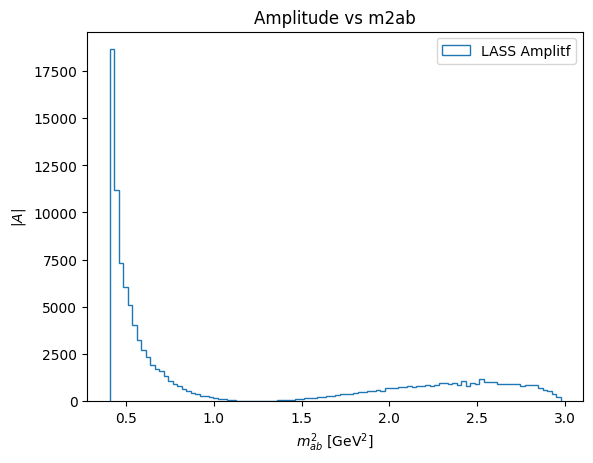

In [14]:
plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(lass_tf), bins=100, histtype='step', label='LASS Amplitf')
#plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(aBW_tf), bins=100, histtype='step', label='BW Amplitf', density=True)
plt.xlabel(r'$m_{ab}^2$ [GeV$^2$]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m2ab')
plt.legend()

Let's now code Jordi's version of the LASS to check what is different.

In [15]:
def lass_jordi(mab2, _amp, _phase, _LASS_a, _LASS_r, _massR, _gammaR, _ma, _mb, _LASS_R, _LASS_phi_R, _LASS_F, _LASS_phi_F):
    pi180inv = np.pi / 180.

    ampl=_amp
    theta=_phase

    s = mab2

    _a = _LASS_a
    _r = _LASS_r
    _R = _LASS_R # Amplitude magnitude of the resonant term
    _phiR = _LASS_phi_R # Phase of the resonant term
    _F = _LASS_F # Amplitude magnitude of the non-resonant term
    _phiF = _LASS_phi_F # Phase of the non-resonant term

    mR=_massR
    gammaR=_gammaR

    fR=1.0 # K*0(1430) has spin zero
    power=1 # Power is 1 for spin zero

    mAB=np.sqrt(mab2) # (_p4_d1+_p4_d2).mass();

    mA=_ma # _p4_d1.mass();
    mB=_mb # _p4_d2.mass();

    pAB=np.sqrt( (((mAB*mAB-mA*mA-mB*mB)*(mAB*mAB-mA*mA-mB*mB)/4.0) - mA*mA*mB*mB)/(mAB*mAB))
    q=pAB

    pR= np.sqrt( (((mR*mR-mA*mA-mB*mB)*(mR*mR-mA*mA-mB*mB)/4.0) - mA*mA*mB*mB)/(mR*mR))

    # Running width.
    g = gammaR*np.power(pAB/pR,power)*(mR/mAB)*fR*fR

    propagator_relativistic_BreitWigner = 1./(mR*mR - mAB*mAB - 1j*mR*g)

	# Non-resonant phase shift
    cot_deltaF = 1.0/(_a*q) + 0.5*_r*q
    qcot_deltaF = 1.0/_a + 0.5*_r*q*q

	# Compute resonant part
    expi2deltaF = (qcot_deltaF + 1j*q)/ (qcot_deltaF - 1j*q)

    #resonant_term_T = _R * complex(np.cos(_phiR + 2 * _phiF), np.sin(_phiR + 2 * _phiF)) * propagator_relativistic_BreitWigner * mR * gammaR * mR / pR * expi2deltaF

	# Compute non-resonant part
    non_resonant_term_F = _F * complex(np.cos(_phiF), np.sin(_phiF)) * (np.cos(_phiF) + cot_deltaF * np.sin(_phiF)) #* np.sqrt(s) / (qcot_deltaF - 1j*q)

	# Add non-resonant and resonant terms
    LASS_contribution = non_resonant_term_F #+ resonant_term_T

    matrixEl = ampl * complex(np.cos(theta*pi180inv), np.sin(theta*pi180inv)) * LASS_contribution

    return matrixEl

In [16]:
lass_jd = lass_jordi(phsp.m2ab(norm_sample), 1.0, 0.0, lass_a.numpy(), lass_r.numpy(), 
                    lass_M.numpy(), lass_G.numpy(), mkz.numpy(), mpi.numpy(), 
                    lass_R.numpy(), lass_phiR.numpy(), lass_F.numpy(), lass_phiF.numpy())

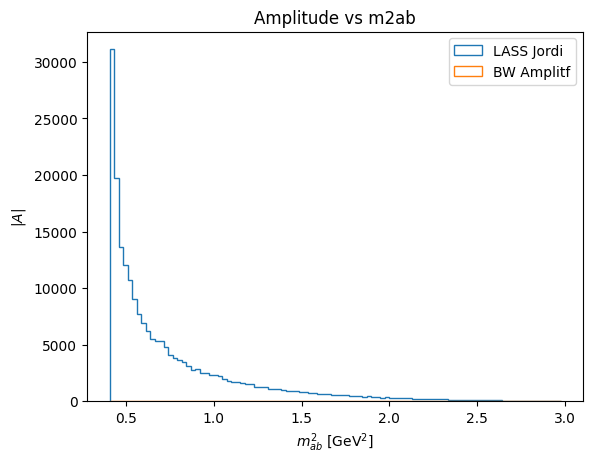

In [17]:
plt.hist(phsp.m2ab(norm_sample), weights = np.power(np.abs(lass_jd),2), bins=100, histtype='step', label='LASS Jordi')
plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(lass_tf), bins=100, histtype='step', label='LASS Amplitf', density=True)
plt.xlabel(r'$m_{ab}^2$ [GeV$^2$]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m2ab')
plt.legend()

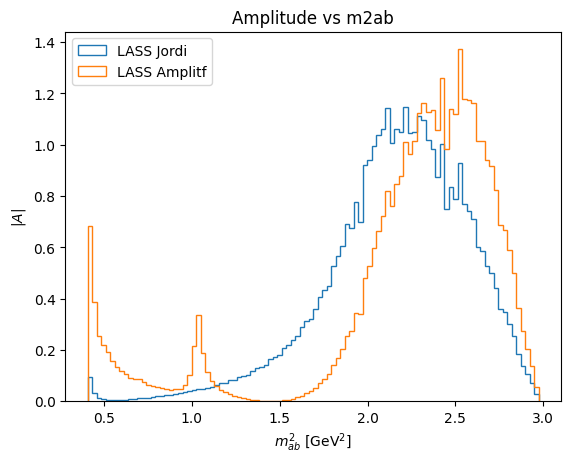

In [28]:
def nonresonant_lass_lineshape_jd(m2ab, a, r, ma, mb):
    r"""LASS line shape, nonresonant part

    .. math::

        LASS(m^2) = \frac{m}{q \cot \delta_b - i q}

    
    with :math:`q` is the momentum of the two-body system and :math:`\delta_b` is the scattering phase shift

    .. math::

        \cot \delta_b = \frac{1}{a q} + \frac{1}{2} r q


    from `Aston et al. Nuclear Physics B, Volume 296, Issue 3 (1988), Pages 493-526 <https://doi.org/10.1016/0550-3213(88)90028-4>`_

    Args:
        m2ab (float): invariant mass squared of the system
        a (float): parameter of the effective range term
        r (float): parameter of the effective range term
        ma (float): mass of particle a
        mb (float): mass of particle b

    Returns:
        complex: the nonresonant LASS amplitude
    """
    m = atfi.sqrt(m2ab)
    q = atfk.two_body_momentum(m, ma, mb)
    # q = atfk.two_body_momentum(m, ma, mb)
    cot_deltab = 1.0 / a / q + 1.0 / 2.0 * r * q
    ampl = atfi.cast_complex(m) / atfi.complex(q * cot_deltab, -q)
    return ampl

def resonant_lass_lineshape_jd(m2ab,
                            m0,
                            gamma0,
                            a,
                            r,
                            ma,
                            mb):
    r"""LASS line shape, resonant part

    .. math::

        LASS(m^2) = BW(m^2) (\cos \delta_b + i \sin \delta_b ) ( m_0^2 \Gamma_0 / q_0 )

    Args:
        m2ab (float): invariant mass squared of the system
        m0 (float): resonance mass
        gamma0 (float): resonance width
        a (float): parameter *a* of the effective range term
        r (float): parameter *r* of the effective range term
        md (float): mass of mother particle 
        mc (float): mass of other particle wrt resonance

    Returns:
        complex: the resonant LASS amplitude
    """
    m = atfi.sqrt(m2ab)
    q = atfk.two_body_momentum(m, ma, mb)
    q0 = atfk.two_body_momentum(m0, ma, mb)
    cot_deltab = atfi.const(1.0) / a / q + atfi.const(0.5) * r * q
    phase = atfi.atan(1.0 / cot_deltab)
    width = gamma0 * q / m * m0 / q0
    ampl = (atfd.relativistic_breit_wigner(m2ab, m0, width) *
            atfi.complex(atfi.cos(phase), atfi.sin(phase)) *
            atfi.cast_complex(m0 * m0 * gamma0 / q0))
    return ampl

def LASS_jordi_tf(m2, a, r, m0, gamma0, ma, mb, amp_res, amp_nr, phase_res, phase_nr):
    m = atfi.sqrt(m2)
    #q0 = atfk.two_body_momentum(md, m0, mc)
    q = atfk.two_body_momentum(m, ma, mb)
    cot_delta_beta = atfi.const(1.0) / a / q + atfi.const(0.5) * r * q
    #delta_beta = atfi.atan(1.0 / cot_delta_beta)
    nr = nonresonant_lass_lineshape_jd(m2, a, r, ma, mb)
    res= atfd.resonant_lass_lineshape(m2, m0, gamma0, a, r, ma, mb)
    lass = atfi.cast_complex(amp_res) * \
        atfi.complex( atfi.cos(phase_res + 2.0*phase_nr), atfi.sin(phase_res + 2.0*phase_nr) ) * \
             atfi.complex( q * cot_delta_beta, q ) / atfi.complex( q * cot_delta_beta, -q ) * res
    lass += atfi.cast_complex(amp_nr) * atfi.complex( atfi.cos(phase_nr), atfi.sin(phase_nr) ) * \
           atfi.cast_complex( atfi.cos(phase_nr) + atfi.sin(phase_nr) * cot_delta_beta ) * nr
    return lass

def lass_jordi(mab2, _amp, _phase, _LASS_a, _LASS_r, _massR, _gammaR, _ma, _mb, _LASS_R, _LASS_phi_R, _LASS_F, _LASS_phi_F):
    pi180inv = np.pi / 180.

    ampl=_amp
    theta=_phase

    s = mab2

    _a = _LASS_a
    _r = _LASS_r
    _R = _LASS_R # Amplitude magnitude of the resonant term
    _phiR = _LASS_phi_R # Phase of the resonant term
    _F = _LASS_F # Amplitude magnitude of the non-resonant term
    _phiF = _LASS_phi_F # Phase of the non-resonant term

    mR=_massR
    gammaR=_gammaR

    fR=1.0 # K*0(1430) has spin zero
    power=1 # Power is 1 for spin zero

    mAB=np.sqrt(mab2) # (_p4_d1+_p4_d2).mass();

    mA=_ma # _p4_d1.mass();
    mB=_mb # _p4_d2.mass();

    pAB=np.sqrt( (((mAB*mAB-mA*mA-mB*mB)*(mAB*mAB-mA*mA-mB*mB)/4.0) - mA*mA*mB*mB)/(mAB*mAB))
    q=pAB

    pR= np.sqrt( (((mR*mR-mA*mA-mB*mB)*(mR*mR-mA*mA-mB*mB)/4.0) - mA*mA*mB*mB)/(mR*mR))

    # Running width.
    g = gammaR*np.power(pAB/pR,power)*(mR/mAB)*fR*fR

    propagator_relativistic_BreitWigner = 1./(mR*mR - mAB*mAB - 1j*mR*g)

	# Non-resonant phase shift
    cot_deltaF = 1.0/(_a*q) + 0.5*_r*q
    qcot_deltaF = 1.0/_a + 0.5*_r*q*q

	# Compute resonant part
    expi2deltaF = (qcot_deltaF + 1j*q)/ (qcot_deltaF - 1j*q)

    resonant_term_T = _R * complex(np.cos(_phiR + 2 * _phiF), np.sin(_phiR + 2 * _phiF)) * expi2deltaF * propagator_relativistic_BreitWigner * mR * gammaR * mR / pR 

	# Compute non-resonant part
    non_resonant_term_F = _F * complex(np.cos(_phiF), np.sin(_phiF)) * (np.cos(_phiF) + cot_deltaF * np.sin(_phiF)) * np.sqrt(s) / (qcot_deltaF - 1j*q)

	# Add non-resonant and resonant terms
    LASS_contribution = non_resonant_term_F + resonant_term_T
    #LASS_contribution = resonant_term_T

    matrixEl = ampl * complex(np.cos(theta*pi180inv), np.sin(theta*pi180inv)) * LASS_contribution

    return matrixEl

lass_jd = lass_jordi(phsp.m2ab(norm_sample), 1.0, 0.0, lass_a.numpy(), lass_r.numpy(), 
                    lass_M.numpy(), lass_G.numpy(), mkz.numpy(), mpi.numpy(), 
                    lass_R.numpy(), lass_phiR.numpy(), lass_F.numpy(), lass_phiF.numpy())


lass_tf = LASS_jordi_tf(phsp.m2ab(norm_sample), lass_a, lass_r, lass_M, lass_G, mkz, mpi, lass_R, lass_F, lass_phiR, lass_phiF)
plt.hist(phsp.m2ab(norm_sample), weights = np.power(np.abs(lass_jd),2), bins=100, histtype='step', label='LASS Jordi', density=True)
plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(lass_tf), bins=100, histtype='step', label='LASS Amplitf', density=True)
plt.xlabel(r'$m_{ab}^2$ [GeV$^2$]')
plt.ylabel(r'$|A|$')
plt.title('Amplitude vs m2ab')
plt.legend()

(array([5.74620950e+00, 3.64721192e+00, 2.52319170e+00, 2.21501736e+00,
        1.97527015e+00, 1.66536090e+00, 1.41934653e+00, 1.27069490e+00,
        1.15217158e+00, 1.01402839e+00, 9.74502691e-01, 9.75282797e-01,
        8.76062444e-01, 7.54473148e-01, 7.10706095e-01, 6.77210453e-01,
        6.41765059e-01, 5.79317606e-01, 5.13689386e-01, 5.26941726e-01,
        4.60994445e-01, 4.64003380e-01, 4.26466234e-01, 4.24519882e-01,
        4.13323848e-01, 3.60746458e-01, 3.33758810e-01, 3.15932336e-01,
        3.10017691e-01, 3.02824322e-01, 2.75181283e-01, 2.72990870e-01,
        2.38067113e-01, 2.38276931e-01, 2.25830415e-01, 2.03565448e-01,
        2.04910637e-01, 1.96502734e-01, 1.80869980e-01, 1.69876889e-01,
        1.70472416e-01, 1.59792253e-01, 1.46145641e-01, 1.46582362e-01,
        1.36866579e-01, 1.29065962e-01, 1.20335921e-01, 1.19990479e-01,
        1.13632428e-01, 1.01845092e-01, 1.00175031e-01, 9.85121696e-02,
        9.23273484e-02, 8.35135677e-02, 8.50720967e-02, 8.064335

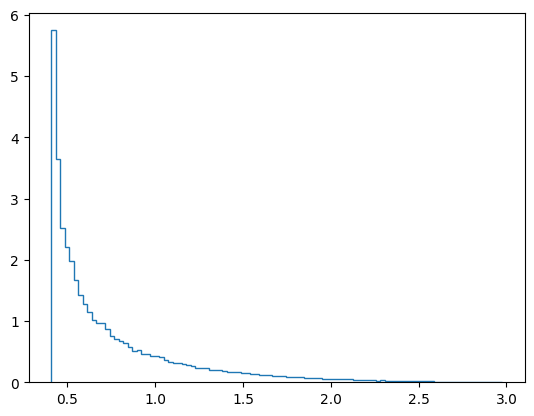

In [ ]:
#plt.hist(phsp.m2ab(norm_sample), weights = atfd.density(lass_tf), bins=100, histtype='step', label='LASS Amplitf', density=True)